In [9]:
import scipy.sparse as sp
import numpy as np
import os
import time
import networkx as nx
from input_data import initialize_dataset,initialize_DBPedia_dataset
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import warnings
from tqdm.notebook import tqdm
from matplotlib.ticker import MaxNLocator
warnings.filterwarnings('ignore')

In [4]:
# nodes to skip for GO datasets
to_skip = ['root', 'go0003674', 'go0005575', 'go0008150']

# all existing HMC benchmarks. 
# The numbers are total nodes for every hierarchy.

datasets = {
                'Enron_corr': 57,
                'Diatoms': 399,
                'ImCLEF07A': 97,
                'ImCLEF07D': 47,
                

                'cellcycle_FUN':500, 
#                 'derisi_FUN':500, 
#                 'eisen_FUN':462, 
#                 'expr_FUN':500, 
#                 'gasch1_FUN':500,
#                 'gasch2_FUN':500,
#                 'seq_FUN':500,
#                 'spo_FUN':500,

                'cellcycle_GO':4126, 
#                 'derisi_GO':4120,
#                 'eisen_GO':3574,
#                 'expr_GO':4132, 
#                 'gasch1_GO':4126, 
#                 'gasch2_GO':4132,
#                 'seq_GO':4134,
#                 'spo_GO':4120 
}

In [10]:
meta = {
        'Law':{'bins':35, 'range':(0,200)},
        'Comedy':{'bins':25, 'range':(0,50)}, 
        'Main':{'bins':40, 'range':(0,250)}, 
        'Engineering':{'bins':60, 'range':(0,60)},
        'MedMentions':{'bins':40, 'range':(0,250)},
        'Enron_corr': {'bins':25, 'range':(0,25)},
        'Diatoms': {'bins':50, 'range':(0,50)},
        'ImCLEF07A': {'bins':25, 'range':(0,25)},
        'ImCLEF07D': {'bins':100, 'range':(0,100)},
        'cellcycle_GO':{'bins':20, 'range':(0,20)},
        'cellcycle_FUN':{'bins':50, 'range':(0,50)}
}

In [15]:
def analyze_graph(dataset, X, Y, g, args):
    tree = args['tree']
    nodes_idx = args['nodes_idx']
    depths = [tree.nodes[node].depth for node in tree.nodes]
    dataByLevel = [0 for _ in range(tree.depth)]
    leafByLevel = [0 for _ in range(tree.depth)]
    numOfParents = [0 for _ in range(Y.shape[1])]
    numOfChildren = [0 for _ in range(Y.shape[1])]

    Y_sum = np.sum(Y, axis = 0)
    for node in tree.nodes:
        if node.lower() not in to_skip:
            
            if "GO" in dataset:
                dataByLevel[tree.nodes[node].depth-1] += Y_sum[nodes_idx[node.upper()]-4]
                numOfParents[nodes_idx[node.upper()]-4] = len(tree.nodes[node].parents)
                numOfChildren[nodes_idx[node.upper()]-4] = len(tree.nodes[node].children)
            else:
                dataByLevel[tree.nodes[node].depth-1] += Y_sum[nodes_idx[node]-1]
                numOfParents[nodes_idx[node]-1] = len(tree.nodes[node].parents)
                numOfChildren[nodes_idx[node]-1] = len(tree.nodes[node].children)

                
            if len(tree.nodes[node].children) == 0:
                    leafByLevel[tree.nodes[node].depth-1] += 1
                    
    
    
    x, y = np.unique(np.sum(Y, axis = 0), return_counts=True)
    
    n_data = args['n_data']
    n_fewshot = 0
    for i in range(len(x)):
        if x[i] <= n_data:
            n_fewshot+=x[i]
    
    print ('tree depth:', tree.depth)
    print ('# of class: %d, # of data: %d'%(Y.shape[1], Y.shape[0]))
    print ("%% of nodes with less than %d data records: %.1f %%"%(n_data, float(n_fewshot)/Y.shape[1]*100))
    print ("# of nodes with less than %d data records: %d "%(n_data, n_fewshot))
    print ('average # of data per class: %.2f'%(sum(Y_sum)/Y.shape[1]))
    print ("median # of data per class: %.2f"%(np.median(Y_sum)))
    print ('averaged # of parents: %.2f'%(sum(numOfParents)/Y.shape[1]))
    print ('averaged # of children: %.2f from %d nodes'%(np.average([i for i in numOfChildren if i !=0]), len([i for i in numOfChildren if i !=0])))


    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
    

    axes[0].bar(*np.unique(Y_sum, return_counts=True), color = "#1c9099")
    axes[0].set_xlabel('data per node', fontsize = 16)
    axes[0].set_xlim(meta[dataset]['range'])

    axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[0].set_ylabel('# of nodes', fontsize = 16)
    if 'Law' in dataset:
        axes[0].xaxis.set_ticks(np.arange(meta[dataset]['range'][0], meta[dataset]['range'][1], 30))
    elif "Main" in dataset:
        axes[0].xaxis.set_ticks(np.arange(meta[dataset]['range'][0], meta[dataset]['range'][1], 35))
    axes[0].xaxis.set_tick_params(labelsize=10)
    axes[0].yaxis.set_tick_params(labelsize=12)

    
    axes[1].bar([i +1 for i in range(len(dataByLevel))], dataByLevel)
    axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[1].set_xlabel('Tree Depth', fontsize = 16)
    axes[1].set_ylabel('# of data', fontsize = 16)

    axes[2].bar(*np.unique(depths, return_counts = True))
    axes[2].xaxis.set_major_locator(MaxNLocator(integer=True))
    axes[2].bar([i +1 for i in range(len(leafByLevel))], leafByLevel, color = 'r')
    axes[2].set_xlabel('Tree Depth', fontsize = 16)
    axes[2].set_ylabel('# of nodes', fontsize = 16)    
    
    
    axes[3].bar(*np.unique(np.sum(Y, axis = 1), return_counts=True))
    if 'CLEF' in dataset:
        axes[3].xaxis.set_ticks(np.arange(0, 4, 1))
        axes[3].set_xlim([0, 4])
        
    axes[3].set_xlabel('# of y', fontsize = 16)
    axes[3].set_ylabel('data counts', fontsize = 16)
    fig.tight_layout()

    plt.show()


In [12]:
args = {'dataset':'cellcycle_FUN',
        'random_seed':5656,
        'n_data': 5, # arg for checking "few" shot learning
       }

MedMentions/
tree depth: 8
# of class: 127, # of data: 4392
% of nodes with less than 5 data records: 1.6 %
# of nodes with less than 5 data records: 2 
average # of data per class: 1242.39
median # of data per class: 623.00
averaged # of parents: 0.99
averaged # of children: 2.82 from 44 nodes


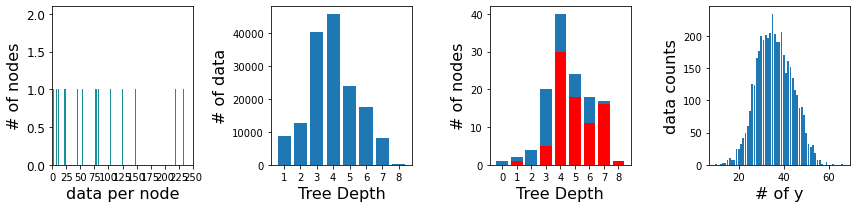

Law/
tree depth: 10
# of class: 958, # of data: 61974
% of nodes with less than 5 data records: 0.0 %
# of nodes with less than 5 data records: 0 
average # of data per class: 769.27
median # of data per class: 90.00
averaged # of parents: 1.33
averaged # of children: 2.96 from 431 nodes


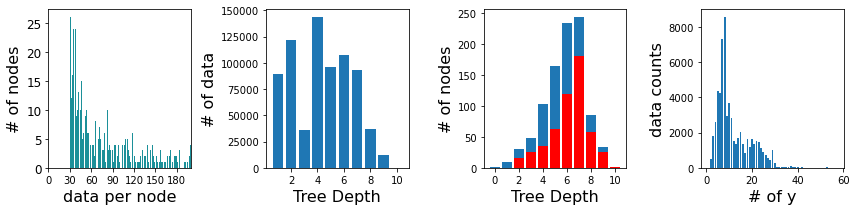

Comedy/
tree depth: 6
# of class: 395, # of data: 8333
% of nodes with less than 5 data records: 1.3 %
# of nodes with less than 5 data records: 5 
average # of data per class: 101.03
median # of data per class: 16.00
averaged # of parents: 1.14
averaged # of children: 3.52 from 128 nodes


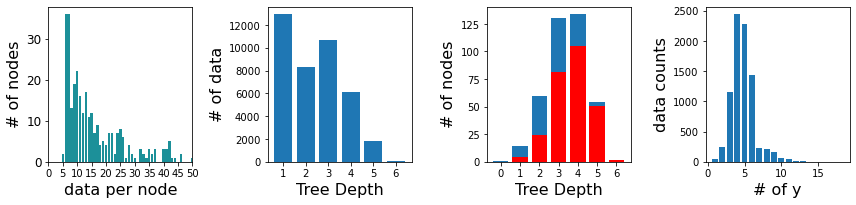

Main/
tree depth: 7
# of class: 147, # of data: 15310
% of nodes with less than 5 data records: 0.0 %
# of nodes with less than 5 data records: 0 
average # of data per class: 661.05
median # of data per class: 172.00
averaged # of parents: 1.29
averaged # of children: 2.68 from 71 nodes


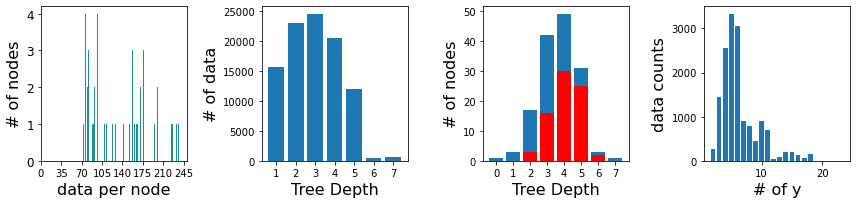

Engineering/
tree depth: 7
# of class: 587, # of data: 22735
% of nodes with less than 5 data records: 0.0 %
# of nodes with less than 5 data records: 0 
average # of data per class: 283.74
median # of data per class: 38.00
averaged # of parents: 1.52
averaged # of children: 4.12 from 216 nodes


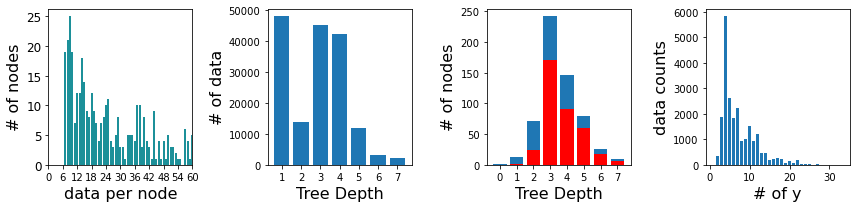

In [16]:
for folder_name in ['MedMentions/','Law/' ,'Comedy/', 'Main/', 'Engineering/']:
    dataset = folder_name[:-1]
    args['dataset'] = dataset
    args['folderpath'] = folder_name
    train, val, test = initialize_DBPedia_dataset(args)

    
    X = np.concatenate((train.X, val.X, test.X), axis = 0)
    Y = np.concatenate((train.Y[:,train.to_eval], val.Y[:,val.to_eval], test.Y[:,test.to_eval]), axis = 0)
#     X = train.X
#     Y = train.Y[:,train.to_eval]
    
    analyze_graph(dataset, X, Y, train.g, args)

Enron_corr
tree depth: 3
# of class: 56, # of data: 988
% of nodes with less than 5 data records: 17.9 %
# of nodes with less than 5 data records: 10 
average # of data per class: 90.23
median # of data per class: 16.00
averaged # of parents: 0.98
averaged # of children: 15.00 from 3 nodes


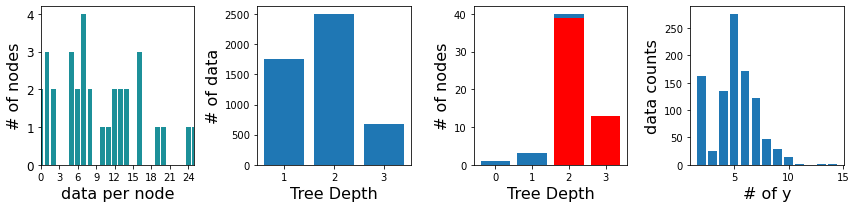

Diatoms
tree depth: 3
# of class: 398, # of data: 2065
% of nodes with less than 5 data records: 56.3 %
# of nodes with less than 5 data records: 224 
average # of data per class: 10.10
median # of data per class: 5.00
averaged # of parents: 1.00
averaged # of children: 3.12 from 86 nodes


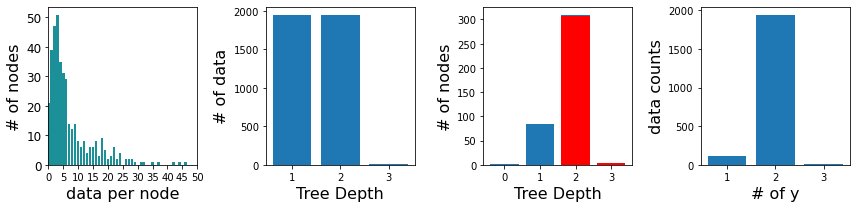

ImCLEF07A
tree depth: 3
# of class: 96, # of data: 10000
% of nodes with less than 5 data records: 0.0 %
# of nodes with less than 5 data records: 0 
average # of data per class: 312.50
median # of data per class: 119.50
averaged # of parents: 0.99
averaged # of children: 2.66 from 32 nodes
adjust


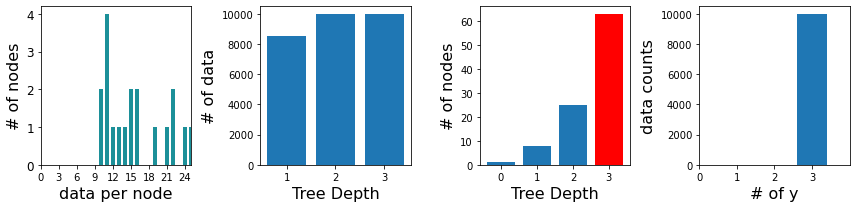

ImCLEF07D
tree depth: 3
# of class: 46, # of data: 10000
% of nodes with less than 5 data records: 0.0 %
# of nodes with less than 5 data records: 0 
average # of data per class: 652.17
median # of data per class: 137.00
averaged # of parents: 1.28
averaged # of children: 2.11 from 19 nodes
adjust


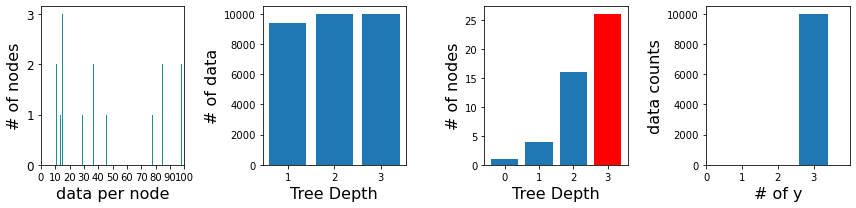

cellcycle_FUN
tree depth: 6
# of class: 499, # of data: 1628
% of nodes with less than 5 data records: 46.9 %
# of nodes with less than 5 data records: 234 
average # of data per class: 28.45
median # of data per class: 7.00
averaged # of parents: 1.00
averaged # of children: 2.71 from 174 nodes


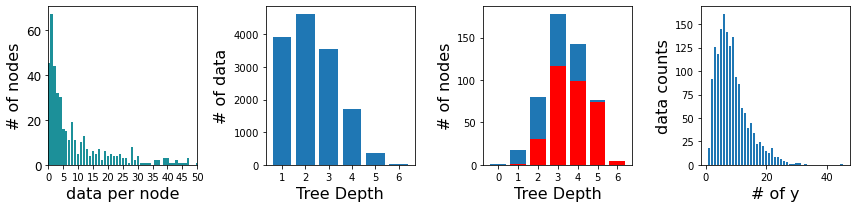

cellcycle_GO
tree depth: 12
# of class: 4122, # of data: 1625
% of nodes with less than 5 data records: 75.0 %
# of nodes with less than 5 data records: 3092 
average # of data per class: 12.49
median # of data per class: 2.00
averaged # of parents: 1.41
averaged # of children: 2.78 from 2081 nodes


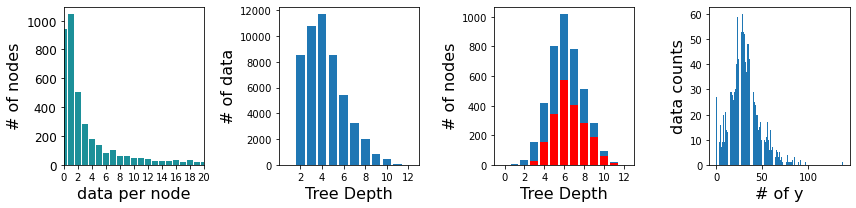

In [39]:
for dataset in datasets:
    args['dataset'] = dataset
    args['arff_dir_path'] = 'datasets/'
    train, val, test = initialize_dataset(dataset, args)
    
#     if dataset not in ['Enron_corr', 'ImCLEF07A', 'ImCLEF07D', 'Diatoms'] :
#         X = np.concatenate((train.X, val.X, test.X), axis = 0)
#         Y = np.concatenate((train.Y[:,train.to_eval], val.Y[:,val.to_eval], test.Y[:,test.to_eval]), axis = 0)
#     else:
#         X = np.concatenate((train.X, test.X), axis = 0)
#         Y = np.concatenate((train.Y[:,train.to_eval], test.Y[:,test.to_eval]), axis = 0)
    X = train.X
    Y = train.Y[:,train.to_eval]
    
    analyze_graph(dataset, X, Y, train.g, args)
